# Book Cover in Recommender System

### import requirements

In [39]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import cv2
import urllib.request

In [86]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import concatenate
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

### --- classes and functions ---

In [4]:
class NN_models:

    def create_mlp(Self, dim, regress=False):
        # define our MLP network
        model = Sequential()
        model.add(Dense(8, input_dim=dim, activation="relu"))
        model.add(Dense(4, activation="relu"))

        # check to see if the regression node should be added
        if regress:
            model.add(Dense(1, activation="linear"))

        # return our model
        return model

    def create_cnn(Self, height, width, depth, filters=(16, 32, 64), regress=False):
        # initialize the input shape and channel dimension, assuming
        # TensorFlow/channels-last ordering

        filters = np.asarray(filters)
        input_shape = (height, width, depth)
        chanDim = -1

        # define the model input
        inputs = Input(shape=input_shape)

        # loop over the number of filters
        for i in range(filters.shape[0]):
            # if this is the first CONV layer then set the input
            # appropriately
            f = filters[i]
            if i == 0:
                x = inputs

            # CONV => RELU => BN => POOL
            x = Conv2D(f, (3, 3), padding="same")(x)
            x = Activation("relu")(x)
            x = BatchNormalization(axis=chanDim)(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)

        # flatten the volume, then FC => RELU => BN => DROPOUT
        x = Flatten()(x)
        x = Dense(16)(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Dropout(0.5)(x)

        # apply another FC layer, this one to match the number of nodes
        # coming out of the MLP
        x = Dense(4)(x)
        x = Activation("relu")(x)

        # check to see if the regression node should be added
        if regress:
            x = Dense(1, activation="linear")(x)

        # construct the CNN
        model = Model(inputs, x)

        # return the CNN
        return model

In [48]:
def download_images(df, input_path):
    
    for i in df['isbn'].index:
        file_path_s = input_path + "//" + str(i) + '.jpg'
        url = df.loc[i]['image']
        try:
            urllib.request.urlretrieve(url, file_path_s)
        except: # http 404
            pass


def load_cover_images(df, input_path):
    # initialize our images array
    images = []

    # loop over the indexes of the books
    for i in df['isbn'].index:

        path = input_path + "//" + str(i) + '.jpg'
        #print(path)
        image = cv2.imread(path)
        try:
            outputImage = cv2.resize(image, (32, 32))
        except: # image is empty
            pass
        images.append(outputImage)

    # return our set of images
    return np.array(images)

In [65]:
def create_cover_image_data(train_df, test_df, images, scaling):
    # process and filter data and label per for the CNN

    train_Y = train_df['average_rating']
    test_Y = test_df['average_rating']

    train_images = []
    for j in range(len(train_df['isbn'])):
        train_images.append(images[j - 1])
    test_images = []
    for j in range(len(test_df['isbn'])):
        test_images.append(images[j - 1])

    train_Y = np.asarray(train_Y) / scaling
    test_Y = np.asarray(test_Y) / scaling

    return np.asarray(train_images), train_Y, np.asarray(test_images), test_Y


def create_user_book_data(train_df, test_df, df, scaling):
    # process and filter data and label per for the NN
    train_Y = train_df['average_rating']
    test_Y = test_df['average_rating']

    # Continous data
    cont = ['year', 'pages']
    cs = MinMaxScaler()

    trainCont = cs.fit_transform(train_df[cont])
    testCont = cs.transform(test_df[cont])

    # Categorical data
    #categ = ['author', 'title', 'firstgenre']
    categ = ['author', 'title', 'publisher']

    for j in range(len(categ)):
        bin = LabelBinarizer().fit(df[categ[j]])
        if j == 0:
            trainFull = np.hstack([trainCont, bin.transform(train_df[categ[j]])])
            testFull = np.hstack([testCont, bin.transform(test_df[categ[j]])])
        else:
            trainFull = np.hstack([trainFull, bin.transform(train_df[categ[j]])])
            testFull = np.hstack([testFull, bin.transform(test_df[categ[j]])])

    train_Y = np.asarray(train_Y) / scaling
    test_Y = np.asarray(test_Y) / scaling

    return trainFull, train_Y, testFull, test_Y

In [7]:
def split_data(df, split, n):
    allbooks = random.sample(list(df['isbn']), n)
    split_train = np.around(n * split)
    train = df[df['isbn'].isin(allbooks[0:int(split_train) - 1])]
    test = df[df['isbn'].isin(allbooks[int(split_train):n])]

    return test, train

In [56]:
def NN_fit(train_df, train_Y, test_df, test_Y, model):
    # train the model
    print("[INFO] training model...")
    m = model.fit(train_df, train_Y, validation_data=(test_df, test_Y), epochs=25, batch_size=8)

    # make predictions on the testing data
    print("[INFO] predicting book ratings...")
    preds_test = model.predict(test_df)
    preds_train = model.predict(train_df)

    # compute the difference between the *predicted* book rating and the
    # *actual* rating, then compute the percentage difference and
    # the absolute percentage difference
    diff = preds_test.flatten() - test_Y
    percentDiff = (diff / test_Y) * 100
    absPercentDiff = np.abs(percentDiff)

    # compute the mean and standard deviation of the absolute percentage
    # difference
    mean = np.mean(absPercentDiff)
    std = np.std(absPercentDiff)

    return preds_test, preds_train, mean, std, m.history['val_loss']

## --- main ---

### load dataset

In [9]:
df1 = pd.read_csv('../books_agg.csv', index_col=0)
df1.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age,City,State,Country
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0,"stockton, california, usa",18.0,stockton,california,usa
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0,"timmins, ontario, canada",NaN,timmins,ontario,canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8.0,0.0,"timmins, ontario, canada",NaN,timmins,ontario,canada


In [10]:
df2 = pd.read_csv('../books/GoodReadBooks.csv', error_bad_lines=False)
df2.head(3)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic


In [11]:
df = df1.merge(df2, left_on='ISBN', right_on='isbn')
df.shape

(55412, 27)

In [12]:
df_orig = df
df = df.dropna()
df = df.drop_duplicates(subset='isbn')
df.shape

(3382, 27)

In [13]:
df = df[['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 
         'Image-URL-S', 'average_rating', 'language_code',
         '  num_pages', 'ratings_count', 'text_reviews_count']]

df.columns = ['isbn', 'title', 'author', 'year', 'publisher',
              'image', 'average_rating', 'language_code',
              'pages', 'ratings_count', 'text_reviews_count']

In [14]:
n_books = len(set(df['isbn']))
print(f'There are {n_books} books in the dataset.')

There are 3382 books in the dataset.


### download images

In [67]:
root_path = r'/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn'

In [98]:
if not os.path.isdir(root_path + r'/output'):
    os.mkdir(root_path + r'/output')
save_path = root_path + r'/output'

In [31]:
# download images from web
if not os.path.isdir(root_path + r'/img_s'):
    os.mkdir(root_path + r'/img_s')
input_path = root_path + r'/img_s'
#download_images(df, input_path)

In [ ]:
#df_org = df
df = df.dropna()

### load images

In [87]:
images = load_cover_images(df, input_path)
images = images / 255.0

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//0.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//468.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//938.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1086.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1182.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1189.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1612.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1751.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1881.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//1959.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//2222.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//2245.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//2459.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//2525.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//2752.jpg
/Users/cinny/GitHub/ml_ecommer

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31340.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31348.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31351.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31354.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31358.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31361.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31561.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31590.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31709.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31767.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31776.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31792.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31817.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31822.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//31831.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41110.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41139.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41167.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41184.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41208.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41233.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41255.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41271.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41297.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41306.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41321.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41330.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41340.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41344.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//41348.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46821.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46828.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46833.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46842.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46844.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46845.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46847.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46850.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46851.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46853.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46860.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46863.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46872.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46889.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//46905.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50236.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50237.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50246.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50248.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50256.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50257.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50258.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50262.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50266.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50275.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50282.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50295.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50296.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50303.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//50306.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52836.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52849.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52852.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52853.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52857.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52862.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52864.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52866.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52869.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52870.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52871.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52872.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52873.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52874.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//52876.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54243.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54249.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54253.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54263.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54274.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54290.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54293.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54294.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54295.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54297.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54299.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54302.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54304.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54314.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//54316.jpg
/Users/cin

/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55272.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55274.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55275.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55276.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55280.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55281.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55282.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55283.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55284.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55285.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55286.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55287.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55288.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55290.jpg
/Users/cinny/GitHub/ml_ecommerce/books_amazon/nn/img_s//55293.jpg
/Users/cin

In [50]:
# 1 - CNN based on cover images
# 2 - NN based on dataset
# 3 - combined NN
NN_type = np.asarray([1, 2, 3])  
scaling = 5  # rating normalization

In [114]:
n_train = np.asarray([20, 200, 500, 1000, 1500, 2000, 2200, 2500, 3300, df.shape[0]])

In [115]:
# cols: number of books; image based RMSE, data based RMSE, mix based RMSE
RMS = np.zeros((n_train.shape[0], 4))
c = -1

In [116]:
for u in n_train:
    c += 1
    RMS[c, 0] = u

    test_df, train_df = split_data(df, 0.75, u)

    for n_type in NN_type:
        preds = []
        loss_vec = []
        train_vec = []
        
        # create model
        model = NN_models()

        if n_type == 1:
            model_CNN = model.create_cnn(32, 32, 3, regress=True)
            opt = Adam(lr=1e-3, decay=1e-3 / 200)
            model_CNN.compile(loss="mean_absolute_percentage_error", optimizer=opt)
            [train_images, train_Y, test_images, test_Y] = create_cover_image_data(train_df, test_df, images, scaling)
            [preds_test, preds_train, mean, std, loss] = NN_fit(train_images, train_Y, test_images, test_Y, model_CNN)
            np.savetxt(save_path + r'/pred_test_CNN_' + str(u) + '.csv', preds_test)
            np.savetxt(save_path + r'/preds_train_CNN_' + str(u) + '.csv', preds_train)
            np.savetxt(save_path + r'/loss_CNN_' + str(u) + '.csv', loss)
            rmse_test = np.sqrt(np.mean((preds_test * scaling - np.asarray(test_Y.reshape(-1, 1)) * scaling) ** 2))
            rmse_train = np.sqrt(np.mean((preds_train * scaling - np.asarray(train_Y.reshape(-1, 1)) * scaling) ** 2))
            with open(save_path + r'/RMSE_test_CNN_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_test)
            RMS[c, n_type] = rmse_test
            with open(save_path + r'/RMSE_train_CNN_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_train)
            RMS[c, n_type] = rmse_test
        
        elif n_type == 2:
            [trainFull, train_Y, testFull, test_Y] = create_user_book_data(train_df, test_df, df, scaling)
            model_NN = model.create_mlp(trainFull.shape[1], regress=True)
            opt = Adam(lr=1e-3, decay=1e-3 / 200)
            model_NN.compile(loss="mean_absolute_percentage_error", optimizer=opt)
            [preds_test, preds_train, mean, std, loss] = NN_fit(trainFull, train_Y, testFull, test_Y, model_NN)
            np.savetxt(save_path + r'/preds_test_MLP_NN_' + str(u) + '.csv', preds_test)
            np.savetxt(save_path + r'/preds_train_MLP_NN_' + str(u) + '.csv', preds_train)
            np.savetxt(save_path + r'/loss_MLP_NN_' + str(u) + '.csv', loss)
            rmse_test = np.sqrt(np.mean((preds_test * scaling - np.asarray(test_Y.reshape(-1, 1)) * scaling) ** 2))
            rmse_train = np.sqrt(np.mean((preds_train * scaling - np.asarray(train_Y.reshape(-1, 1)) * scaling) ** 2))
            with open(save_path + r'/RMSE_test_MLP_NN_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_test)
            RMS[c, n_type] = rmse_test
            with open(save_path + r'/RMSE_train_MLP_NN_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_train)
            RMS[c, n_type] = rmse_test
        
        else:

            # create the MLP and CNN models

            mlp = model.create_mlp(trainFull.shape[1], regress=False)
            cnn = model.create_cnn(32, 32, 3, regress=False)

            # create the input to our final set of layers as the *output* of both
            # the MLP and CNN
            combinedInput = concatenate([mlp.output, cnn.output])
            # our final FC layer head will have two dense layers, the final one
            # being our regression head
            x = Dense(4, activation="relu")(combinedInput)
            x = Dense(1, activation="linear")(x)

            # our final model will accept categorical/numerical data on the MLP
            # input and images on the CNN input, outputting a single value (the
            # predicted price of the house)
            model = Model(inputs=[mlp.input, cnn.input], outputs=x)
            opt = Adam(lr=1e-3, decay=1e-3 / 200)
            model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

            # train the model
            print("[INFO] training model...")
            m = model.fit(
                [trainFull, train_images], train_Y,
                validation_data=([testFull, test_images], test_Y),
                epochs=25, batch_size=8)

            # make predictions on the testing data
            print("[INFO] predicting book ratings...")
            preds_test = model.predict([testFull, test_images])
            preds_train = model.predict([trainFull, train_images])

            diff = preds_test.flatten() - test_Y
            percentDiff = (diff / test_Y) * 100
            absPercentDiff = np.abs(percentDiff)

            # compute the mean and standard deviation of the absolute percentage
            # difference
            mean = np.mean(absPercentDiff)
            std = np.std(absPercentDiff)
            loss = m.history['val_loss']

            np.savetxt(save_path + r'/preds_test_mix_' + str(u) + '.csv', preds_test)
            np.savetxt(save_path + r'/preds_train_mix_' + str(u) + '.csv', preds_train)
            np.savetxt(save_path + r'/loss_Mix_' + str(u) + '.csv', loss)
            rmse_test = np.sqrt(np.mean((preds_test * scaling - np.asarray(test_Y.reshape(-1, 1)) * scaling) ** 2))
            rmse_train = np.sqrt(np.mean((preds_train * scaling - np.asarray(train_Y.reshape(-1, 1)) * scaling) ** 2))
            with open(save_path + r'/RMSE_test_MIX_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_test)
            RMS[c, n_type] = rmse_test
            with open(save_path + r'/RMSE_train_MIX_' + str(u) + '.txt', 'w') as f:
                f.write('%f' % rmse_train)
            RMS[c, n_type] = rmse_test

[INFO] training model...
Epoch 1/25
2/2 [==============================] - 1s 376ms/step - loss: 60.8121 - val_loss: 91.2307
Epoch 2/25
2/2 [==============================] - 0s 48ms/step - loss: 62.4401 - val_loss: 92.1634
Epoch 3/25
2/2 [==============================] - 0s 49ms/step - loss: 81.0263 - val_loss: 90.5808
Epoch 4/25
2/2 [==============================] - 0s 50ms/step - loss: 64.8873 - val_loss: 86.7556
Epoch 5/25
2/2 [==============================] - 0s 52ms/step - loss: 37.8710 - val_loss: 85.6722
Epoch 6/25
2/2 [==============================] - 0s 54ms/step - loss: 70.1102 - val_loss: 84.5138
Epoch 7/25
2/2 [==============================] - 0s 48ms/step - loss: 63.7641 - val_loss: 81.9745
Epoch 8/25
2/2 [==============================] - 0s 47ms/step - loss: 62.9985 - val_loss: 81.1057
Epoch 9/25
2/2 [==============================] - 0s 48ms/step - loss: 47.6438 - val_loss: 82.5934
Epoch 10/25
2/2 [==============================] - 0s 46ms/step - loss: 77.9358 - v

19/19 [==============================] - 1s 31ms/step - loss: 86.7566 - val_loss: 98.6527
Epoch 7/25
19/19 [==============================] - 1s 30ms/step - loss: 74.5520 - val_loss: 91.1794
Epoch 8/25
19/19 [==============================] - 1s 30ms/step - loss: 66.2181 - val_loss: 41.0515
Epoch 9/25
19/19 [==============================] - 1s 30ms/step - loss: 63.3195 - val_loss: 71.9158
Epoch 10/25
19/19 [==============================] - 1s 30ms/step - loss: 67.4253 - val_loss: 78.4659
Epoch 11/25
19/19 [==============================] - 1s 30ms/step - loss: 66.1922 - val_loss: 74.8534
Epoch 12/25
19/19 [==============================] - 1s 30ms/step - loss: 67.9392 - val_loss: 77.2321
Epoch 13/25
19/19 [==============================] - 1s 30ms/step - loss: 57.5686 - val_loss: 83.8396
Epoch 14/25
19/19 [==============================] - 1s 30ms/step - loss: 50.3456 - val_loss: 77.7976
Epoch 15/25
19/19 [==============================] - 1s 30ms/step - loss: 59.1602 - val_loss: 66.

[INFO] training model...
Epoch 1/25
47/47 [==============================] - 2s 41ms/step - loss: 140.0437 - val_loss: 54.1649
Epoch 2/25
47/47 [==============================] - 1s 27ms/step - loss: 105.6807 - val_loss: 50.0876
Epoch 3/25
47/47 [==============================] - 1s 28ms/step - loss: 93.1982 - val_loss: 78.9396
Epoch 4/25
47/47 [==============================] - 1s 27ms/step - loss: 74.5195 - val_loss: 68.5470
Epoch 5/25
47/47 [==============================] - 1s 27ms/step - loss: 64.4755 - val_loss: 80.9675
Epoch 6/25
47/47 [==============================] - 1s 28ms/step - loss: 57.7479 - val_loss: 54.7426
Epoch 7/25
47/47 [==============================] - 1s 28ms/step - loss: 46.9180 - val_loss: 45.6254
Epoch 8/25
47/47 [==============================] - 1s 29ms/step - loss: 41.3784 - val_loss: 53.6412
Epoch 9/25
47/47 [==============================] - 1s 29ms/step - loss: 37.4967 - val_loss: 74.2617
Epoch 10/25
47/47 [==============================] - 1s 29ms/ste

Epoch 6/25
94/94 [==============================] - 3s 28ms/step - loss: 35.9672 - val_loss: 27.6879
Epoch 7/25
94/94 [==============================] - 3s 27ms/step - loss: 30.3406 - val_loss: 24.1842
Epoch 8/25
94/94 [==============================] - 3s 28ms/step - loss: 23.4908 - val_loss: 18.5206
Epoch 9/25
94/94 [==============================] - 3s 28ms/step - loss: 18.1562 - val_loss: 13.7233
Epoch 10/25
94/94 [==============================] - 3s 27ms/step - loss: 15.1287 - val_loss: 11.4178
Epoch 11/25
94/94 [==============================] - 3s 27ms/step - loss: 12.8434 - val_loss: 10.1775
Epoch 12/25
94/94 [==============================] - 3s 27ms/step - loss: 11.0560 - val_loss: 9.5004
Epoch 13/25
94/94 [==============================] - 3s 27ms/step - loss: 10.4314 - val_loss: 7.2646
Epoch 14/25
94/94 [==============================] - 3s 28ms/step - loss: 9.4798 - val_loss: 7.2956
Epoch 15/25
94/94 [==============================] - 3s 28ms/step - loss: 8.3420 - val_los

141/141 [==============================] - 4s 28ms/step - loss: 10.2538 - val_loss: 7.4528
Epoch 12/25
141/141 [==============================] - 4s 28ms/step - loss: 9.3042 - val_loss: 6.5168
Epoch 13/25
141/141 [==============================] - 4s 28ms/step - loss: 7.8739 - val_loss: 6.5991
Epoch 14/25
141/141 [==============================] - 4s 28ms/step - loss: 7.2627 - val_loss: 6.1619
Epoch 15/25
141/141 [==============================] - 4s 29ms/step - loss: 6.8605 - val_loss: 5.8630
Epoch 16/25
141/141 [==============================] - 4s 28ms/step - loss: 6.3026 - val_loss: 5.5296
Epoch 17/25
141/141 [==============================] - 4s 30ms/step - loss: 5.8798 - val_loss: 5.6645
Epoch 18/25
141/141 [==============================] - 4s 29ms/step - loss: 5.9020 - val_loss: 5.6035
Epoch 19/25
141/141 [==============================] - 4s 28ms/step - loss: 5.6940 - val_loss: 5.4927
Epoch 20/25
141/141 [==============================] - 4s 28ms/step - loss: 5.6636 - val_loss

188/188 [==============================] - 5s 28ms/step - loss: 5.9225 - val_loss: 5.6718
Epoch 16/25
188/188 [==============================] - 5s 29ms/step - loss: 5.7913 - val_loss: 5.7283
Epoch 17/25
188/188 [==============================] - 5s 28ms/step - loss: 5.7282 - val_loss: 5.9023
Epoch 18/25
188/188 [==============================] - 5s 28ms/step - loss: 5.8253 - val_loss: 5.4875
Epoch 19/25
188/188 [==============================] - 5s 27ms/step - loss: 5.8028 - val_loss: 5.4529
Epoch 20/25
188/188 [==============================] - 5s 28ms/step - loss: 5.6257 - val_loss: 5.4915
Epoch 21/25
188/188 [==============================] - 5s 28ms/step - loss: 5.6462 - val_loss: 5.5736
Epoch 22/25
188/188 [==============================] - 5s 28ms/step - loss: 5.6425 - val_loss: 5.8382
Epoch 23/25
188/188 [==============================] - 5s 28ms/step - loss: 5.6044 - val_loss: 5.3606
Epoch 24/25
188/188 [==============================] - 5s 28ms/step - loss: 5.5108 - val_loss:

207/207 [==============================] - 6s 28ms/step - loss: 5.6223 - val_loss: 5.4450
Epoch 20/25
207/207 [==============================] - 6s 28ms/step - loss: 5.5924 - val_loss: 5.4910
Epoch 21/25
207/207 [==============================] - 6s 28ms/step - loss: 5.5789 - val_loss: 5.3980
Epoch 22/25
207/207 [==============================] - 6s 28ms/step - loss: 5.5806 - val_loss: 5.4018
Epoch 23/25
207/207 [==============================] - 6s 28ms/step - loss: 5.5255 - val_loss: 5.4089
Epoch 24/25
207/207 [==============================] - 6s 28ms/step - loss: 5.5357 - val_loss: 5.4294
Epoch 25/25
207/207 [==============================] - 6s 27ms/step - loss: 5.5384 - val_loss: 5.5001
[INFO] predicting book ratings...
[INFO] training model...
Epoch 1/25
207/207 [==============================] - 1s 6ms/step - loss: 46.3452 - val_loss: 6.6503
Epoch 2/25
207/207 [==============================] - 1s 4ms/step - loss: 5.5309 - val_loss: 5.8454
Epoch 3/25
207/207 [==================

235/235 [==============================] - 6s 27ms/step - loss: 5.4766 - val_loss: 5.4543
Epoch 24/25
235/235 [==============================] - 7s 28ms/step - loss: 5.4726 - val_loss: 5.4049
Epoch 25/25
235/235 [==============================] - 7s 28ms/step - loss: 5.4303 - val_loss: 5.4133
[INFO] predicting book ratings...
[INFO] training model...
Epoch 1/25
235/235 [==============================] - 1s 6ms/step - loss: 17.6915 - val_loss: 8.8103
Epoch 2/25
235/235 [==============================] - 1s 4ms/step - loss: 7.4041 - val_loss: 7.1944
Epoch 3/25
235/235 [==============================] - 1s 4ms/step - loss: 5.3859 - val_loss: 6.6588
Epoch 4/25
235/235 [==============================] - 1s 4ms/step - loss: 4.0684 - val_loss: 6.4630
Epoch 5/25
235/235 [==============================] - 1s 4ms/step - loss: 3.5651 - val_loss: 5.9320
Epoch 6/25
235/235 [==============================] - 1s 4ms/step - loss: 2.8463 - val_loss: 5.7370
Epoch 7/25
235/235 [==========================

310/310 [==============================] - 2s 7ms/step - loss: 24.5153 - val_loss: 6.0529
Epoch 2/25
310/310 [==============================] - 2s 5ms/step - loss: 5.0158 - val_loss: 5.9159
Epoch 3/25
310/310 [==============================] - 2s 5ms/step - loss: 3.9416 - val_loss: 5.8872
Epoch 4/25
310/310 [==============================] - 2s 6ms/step - loss: 3.4482 - val_loss: 5.7150
Epoch 5/25
310/310 [==============================] - 2s 6ms/step - loss: 3.0562 - val_loss: 5.3977
Epoch 6/25
310/310 [==============================] - 1s 4ms/step - loss: 2.8387 - val_loss: 5.5517
Epoch 7/25
310/310 [==============================] - 1s 4ms/step - loss: 2.6747 - val_loss: 5.3050
Epoch 8/25
310/310 [==============================] - 2s 5ms/step - loss: 2.4770 - val_loss: 5.1362
Epoch 9/25
310/310 [==============================] - 2s 5ms/step - loss: 2.2697 - val_loss: 5.0509
Epoch 10/25
310/310 [==============================] - 2s 5ms/step - loss: 2.2283 - val_loss: 5.0420
Epoch 11/

317/317 [==============================] - 0s 827us/step - loss: 2.4356 - val_loss: 5.3806
Epoch 6/25
317/317 [==============================] - 0s 747us/step - loss: 2.2413 - val_loss: 5.2783
Epoch 7/25
317/317 [==============================] - 0s 740us/step - loss: 2.0520 - val_loss: 5.1733
Epoch 8/25
317/317 [==============================] - 0s 724us/step - loss: 1.9876 - val_loss: 5.0769
Epoch 9/25
317/317 [==============================] - 0s 738us/step - loss: 1.8879 - val_loss: 5.0638
Epoch 10/25
317/317 [==============================] - 0s 745us/step - loss: 1.8199 - val_loss: 5.0528
Epoch 11/25
317/317 [==============================] - 0s 722us/step - loss: 1.7190 - val_loss: 5.0021
Epoch 12/25
317/317 [==============================] - 0s 758us/step - loss: 1.7233 - val_loss: 4.9250
Epoch 13/25
317/317 [==============================] - 0s 754us/step - loss: 1.5852 - val_loss: 5.1059
Epoch 14/25
317/317 [==============================] - 0s 753us/step - loss: 1.6106 - val

In [117]:
fullRMSE = pd.DataFrame(
    {'n_users': RMS[:, 0], 'image_based': RMS[:, 1], 'data_based': RMS[:, 2], 'mixed_model': RMS[:, 3]})
fullRMSE.to_csv(save_path + r'/all_RMSE.csv', index=False)

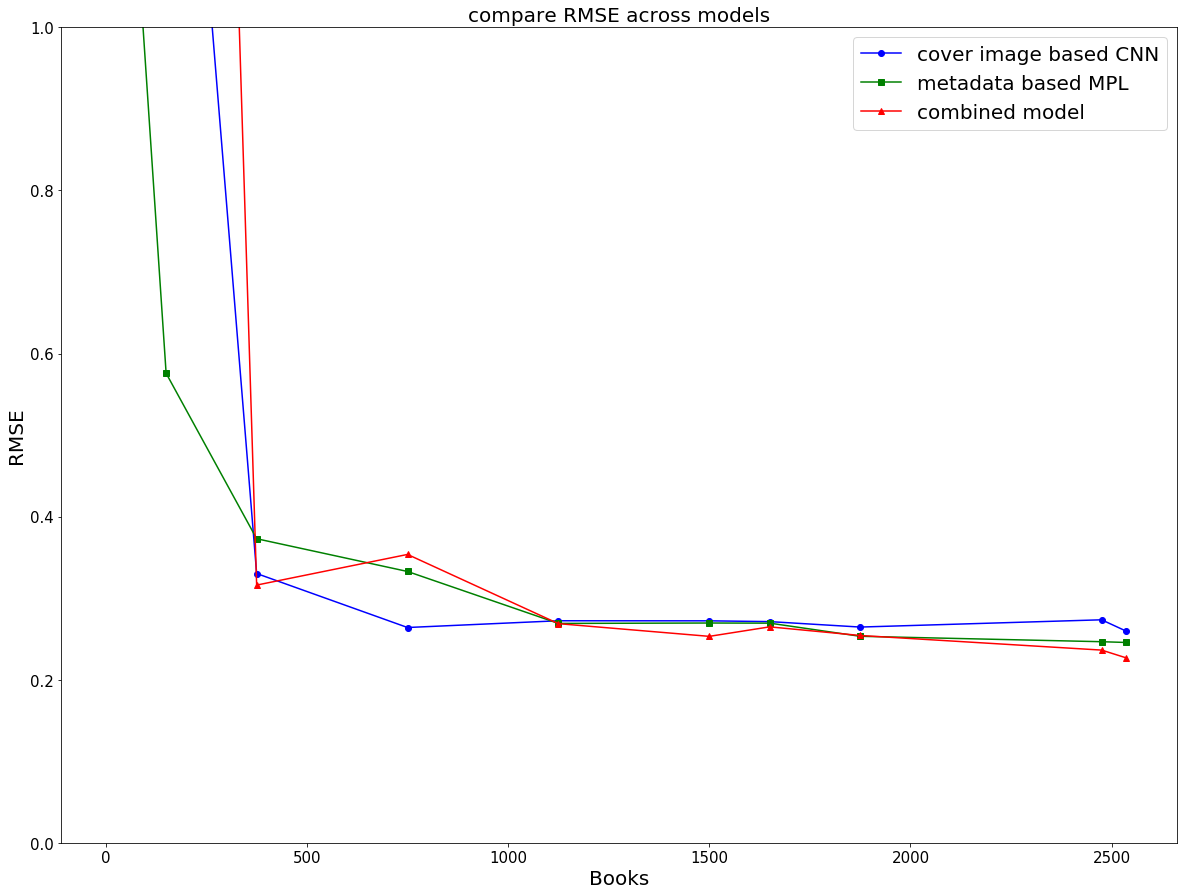

In [118]:
plt.figure(figsize=(20,15))
fmt_CNN = '[o][-][b]'
fmt_MLP = '[s][-][r]'
fmt_Mix = '[*][-][g]'
plt.plot(RMS[:, 0] * 0.75, RMS[:, 1], 'bo-', label='cover image based CNN', linewidth=1.5)
plt.plot(RMS[:, 0] * 0.75, RMS[:, 2], 'gs-', label='metadata based MPL', linewidth=1.5)
plt.plot(RMS[:, 0] * 0.75, RMS[:, 3], 'r^-', label='combined model', linewidth=1.5)
plt.ylim(0, 1)

# add labels and save to disk
plt.title('compare RMSE across models', fontsize=20)
plt.xlabel('Books', fontsize=20)
plt.ylabel('RMSE', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=20)
plt.savefig(save_path + r'/RMSE_vs_users.png')